# Ticino Covid - Data Analysis and modelling

Modeling SARS-CoV-2 epidemic in Ticino, Switzerland as a quasi-reaction system from scratch.


In [38]:
# Import libraries
import pandas as pd
import numpy as np

## Loading data

In [44]:
# Load dataset using pandas
df = pd.read_csv('https://raw.githubusercontent.com/openZH/covid_19/master/fallzahlen_kanton_total_csv_v2/COVID19_Fallzahlen_Kanton_TI_total.csv')

# Extract only required columns: cases, recovers, and deaths
COLUMNS = [
  "date",
  "ncumul_conf",
  "ncumul_released",
  "ncumul_deceased",
]
df = df[COLUMNS]

# Select only rows with data
last_nan_index = df["ncumul_released"].last_valid_index()
df = df.iloc[:last_nan_index + 1]

## Compartmental model

$$
\begin{align}
S + I &\xrightarrow{\beta_1} 2I \\
I &\xrightarrow{\beta_2} R \\
I &\xrightarrow{\beta_3} D \\
R &\xrightarrow{\beta_4} S \\
\end{align}
$$

In [40]:
# Products matrix (S, I, R, D)
P = np.array([
  [0, 2, 0, 0],
  [0, 0, 1, 0],
  [0, 0, 0, 1],
  [1, 0, 0, 0],
])

# Reactants matrix (S, I, R, D)
R = np.array([
  [1, 1, 0, 0],
  [0, 1, 0, 0],
  [0, 1, 0, 0],
  [0, 0, 1, 0],
])

# Net effect matrix
V = P - R

print("Net effect matrix")
print(V)

Net effect matrix
[[-1  1  0  0]
 [ 0 -1  1  0]
 [ 0 -1  0  1]
 [ 1  0 -1  0]]


## Restructuring data

In [54]:
# Compute number of active cases
active = df["ncumul_conf"] - df["ncumul_released"] - df["ncumul_deceased"]

# Create new DF with active cases
df_model = pd.DataFrame({
  "date": df["date"],
  "I": active,
  "R": df["ncumul_released"],
  "D": df["ncumul_deceased"],
})

# Compute fields
total_ticino_population_2020 = 345707
df_model.loc[0, "N"] = total_ticino_population_2020
df_model.loc[:, "N"] = total_ticino_population_2020 - df_model["D"]
df_model["S"] = df_model["N"] - df_model["I"] - df_model["R"]

# Print df
df_model

,date,I,R,D,N,S
0,2020-02-25,0.0,0.0,0,345707.0,345707.0
1,2020-02-26,1.0,0.0,0,345707.0,345706.0
2,2020-02-27,1.0,0.0,0,345707.0,345706.0
3,2020-02-28,1.0,0.0,0,345707.0,345706.0
4,2020-02-29,2.0,0.0,0,345707.0,345705.0
...,...,...,...,...,...,...
437,2021-06-02,28691.0,3402.0,995,344712.0,312619.0
438,2021-06-03,28698.0,3406.0,995,344712.0,312608.0
439,2021-06-04,28705.0,3409.0,995,344712.0,312598.0
440,2021-06-05,28711.0,3410.0,995,344712.0,312591.0


## Visualization

In [57]:
active.max()

28722.0

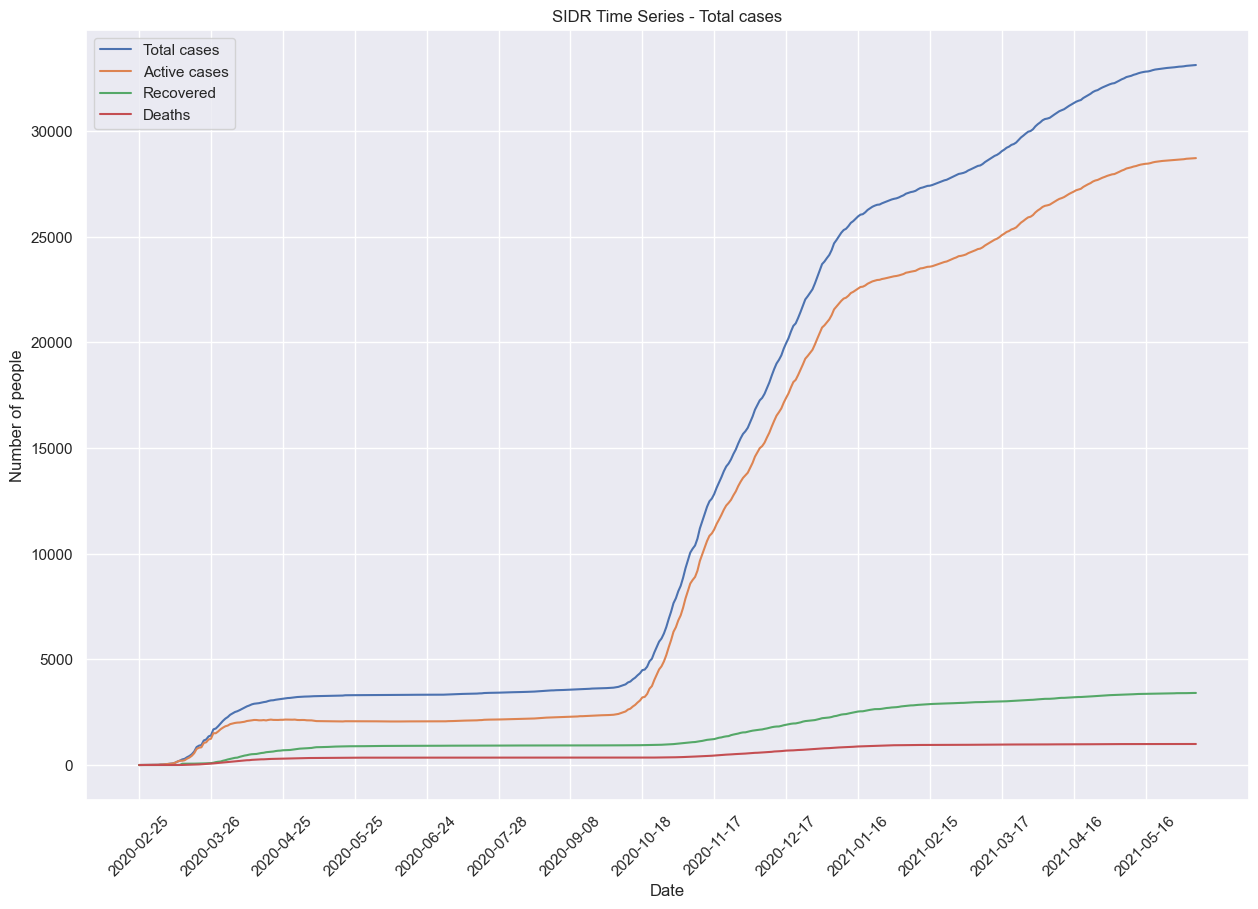

In [69]:
# Active cases vs Deaths vs Recovered vs Infected

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(15, 10))

sns.lineplot(data=df, x="date", y="ncumul_conf", label="Total cases")
sns.lineplot(data=df_model, x="date", y="I", label="Active cases")
sns.lineplot(data=df_model, x="date", y="R", label="Recovered")
sns.lineplot(data=df_model, x="date", y="D", label="Deaths")


plt.title("SIDR Time Series - Total cases")
plt.ylabel("Number of people")
plt.xlabel("Date")

# Adjust ticks (every month)
plt.xticks(np.arange(0, len(df_model), 30), rotation=45)
plt.legend()

plt.show()

## Fitting the model

In [106]:
df_model = df_model[["S", "I", "R", "D"]]
df_diff = df_model.diff()

delta_y = []
# Empty matrix
X = np.matrix([])

# For each row, compute the deltas
for i in range(1, len(df_model) - 1):
  row = df_model.iloc[i]

  # Extract diff
  delta_y.append(df_diff.iloc[i])

  # Now, extract current state of the system
  S = row["S"]
  I = row["I"]
  R = row["R"]
  D = row["D"]
  
  # Compute current state of the system after 1 day for each reaction
  H = np.diag([I*S, I, I, R])
  # delta = Transpose(stoichiometric matrix) * H (current state of the system using formula) * delta_t (1 since it's a day)
  Y_HAT = V.T @ H * 1

  # Append to X
  if X.size == 0:
    X = Y_HAT
  else:
    X = np.vstack((X, Y_HAT))

# Create dataframe using delta_y and X
delta_y_array = np.array(delta_y).reshape(-1, 1)
combined_data = np.hstack((delta_y_array, X))
dataLLA = pd.DataFrame(combined_data)
column_names = ["DeltaY", "R1", "R2", "R3", "R4"]
dataLLA.columns = column_names[:combined_data.shape[1]]
dataLLA

,DeltaY,R1,R2,R3,R4
0,-1.0,-3.457060e+05,0.0,0.0,0.0
1,1.0,3.457060e+05,-1.0,-1.0,0.0
2,0.0,0.000000e+00,1.0,0.0,0.0
3,0.0,0.000000e+00,0.0,1.0,0.0
4,0.0,-3.457060e+05,0.0,0.0,0.0
...,...,...,...,...,...
1755,0.0,0.000000e+00,0.0,28705.0,0.0
1756,-7.0,-8.974800e+09,0.0,0.0,3410.0
1757,6.0,8.974800e+09,-28711.0,-28711.0,0.0
1758,1.0,0.000000e+00,28711.0,0.0,-3410.0


## Estimating reaction rates

In [110]:
# Betas = (X^T * X)^-1 * X^T * DeltaY

# Perform the remaining matrix multiplications
result = np.linalg.inv(X.T @ X) @ X.T @ np.array(delta_y).reshape(-1, 1)

# Print result
for i in range(len(result)):
  print(f"R{i+1} = {result[i][0]}")

R1 = 1.9157210745150076e-08
R2 = 0.0023115494716262315
R3 = 0.0001381431504327888
R4 = 0.015492881092365558
